## Análisis de los datos del patrón de diffracción para la vara de acero

Importamos librerias

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import optimize
from scipy import signal
from scipy import ndimage
import matplotlib


Importamos imagen que usamos para calibrar cm/px

In [2]:
im_calibracion = imageio.imread('~/facultad/labo_4/git_labo_4/informe_1/young_estatico/data/datos_acero/papela.jpg')

calib_rojo = im_calibracion[:,:,0]
calib_verde = im_calibracion[:,:,1]
calib_azul = im_calibracion[:,:,2]

Visualizo las imágenes para ver cual se ve mejor y quedarme con esa para calibrar

In [3]:
%matplotlib qt

fig, ax = plt.subplots(3, figsize=(12,20))
ax1, ax2, ax3 = ax

#recorto las imágenes
calib_rojo = calib_rojo[1250:2250,630:1630]
calib_verde = calib_verde[1250:2250,630:1630]
calib_azul = calib_azul[1250:2250,630:1630]

#muestro las imágenes
ax1.imshow(calib_rojo)
ax2.imshow(calib_verde)
ax3.imshow(calib_azul)
plt.show()


Me quedo con la imagen roja. Ahora la roto para que quede vertical y la vuelvo a recortar

In [4]:
calib_rojo = ndimage.rotate(calib_rojo, 4) #Roto la imagen en 4 grados
calib_rojo = calib_rojo[170:1000,400:600] #Recorto la imagen
fig, ax = plt.subplots(1, figsize=(10,10)) #Grafico
ax.imshow(calib_rojo)
plt.show()

Ahora con la imagen rotada y recortada tomo los puntos de las esquinas de la grilla y los guardo en una lista

In [7]:
plt.imshow(calib_rojo)
puntos_grilla = plt.ginput(15, timeout=60)
plt.show()

Ahora que tengo los puntos de la grilla calculo la cantidad de pixeles que hay por centímetro

In [13]:
puntos_grilla = np.array(puntos_grilla)
#puntos_grilla = puntos_grilla[:,1] #Me quedo sólo con los puntos de la grilla en y
diferencias = np.diff(puntos_grilla)
escala = np.mean(diferencias)
error = np.std(diferencias)
print("En la imagen hay",escala,"+-",error, "px/cm")

En la imagen hay 53.02011931609878 +- 1.5010521918792785 px/cm


Ahora que tengo la escala importo las imágenes a analizar

In [92]:
imagenes = []
nombres_de_los_archivos = ["a0", "a00", "a1", "a2", "a3", "a4", "a5"]

for nombre in nombres_de_los_archivos:
    imagenes.append(imageio.imread("~/facultad/labo_4/git_labo_4/informe_1/young_estatico/data/datos_acero/%s.jpg" %nombre))
    

Recorto las imágenes

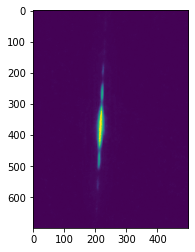

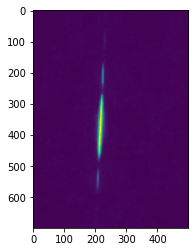

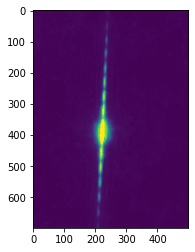

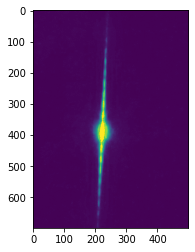

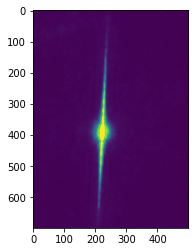

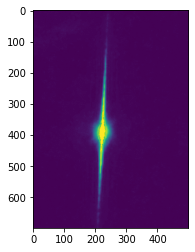

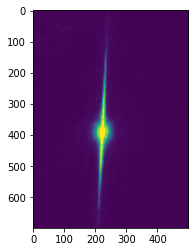

In [93]:
%matplotlib inline

for index, imagen in enumerate(imagenes):
    imagenes[index] = imagen[1400:2100,1050:1550]
    imagenes[index] = imagenes[index][:,:,0] #me quedo con la componente roja
    plt.imshow(imagenes[index])
    plt.show()


Roto las imágenes

In [94]:
angulos = [2.7, 2.5, 2.9, 2.8, 2.8, 2.8, 2.8]
for index, imagen in enumerate(imagenes):
    angulo = angulos[index]
    imagenes[index] = ndimage.rotate(imagen, angulo)


Chequeo que estén bien rotadas

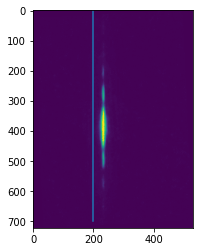

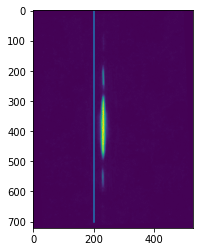

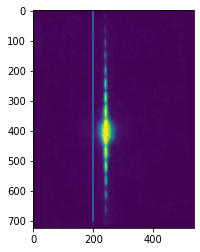

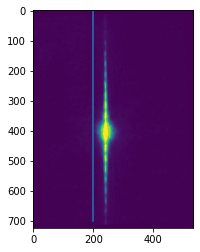

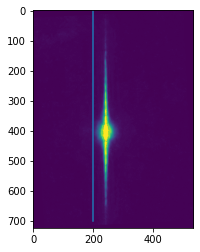

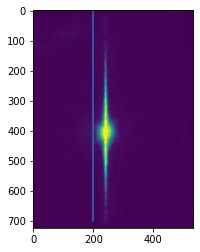

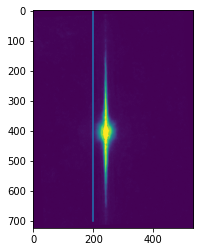

In [97]:
for imagen in imagenes:
    plt.imshow(imagen)
    plt.plot([200,200],[0,700])
    plt.show()

Sumo todos los valores de las filas

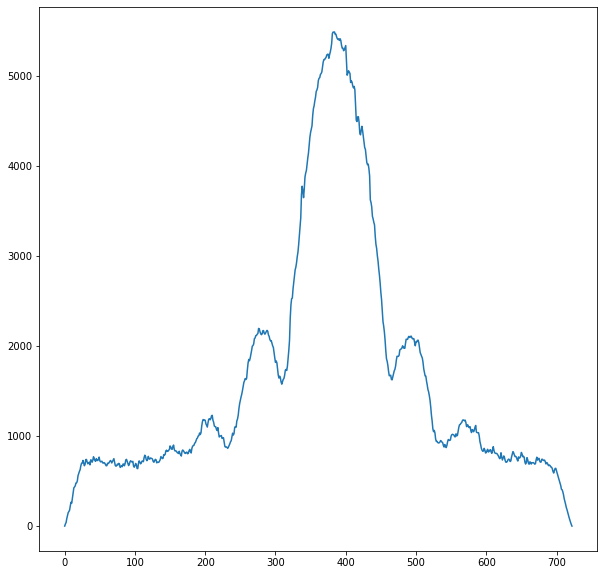

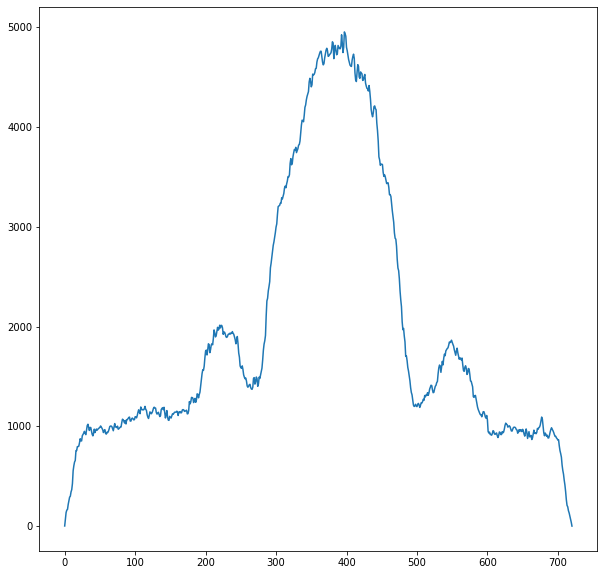

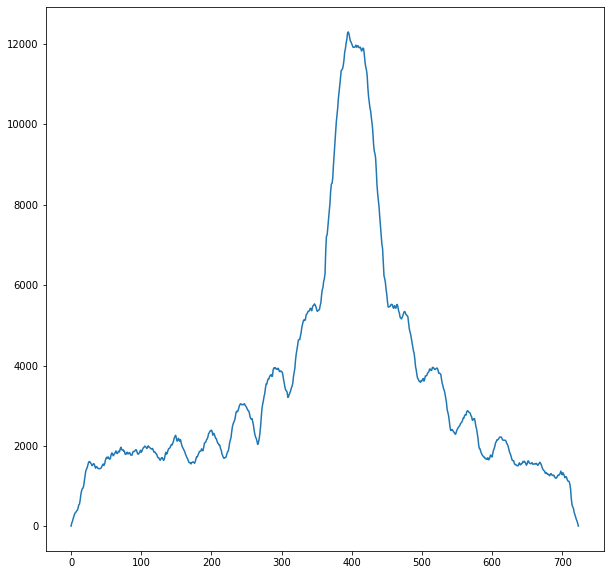

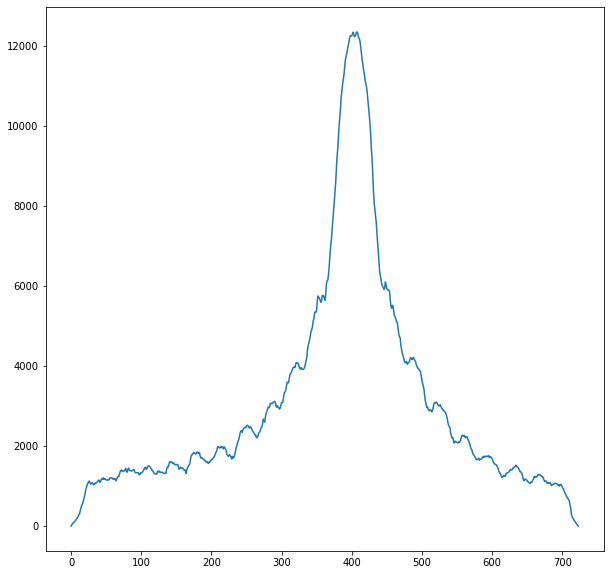

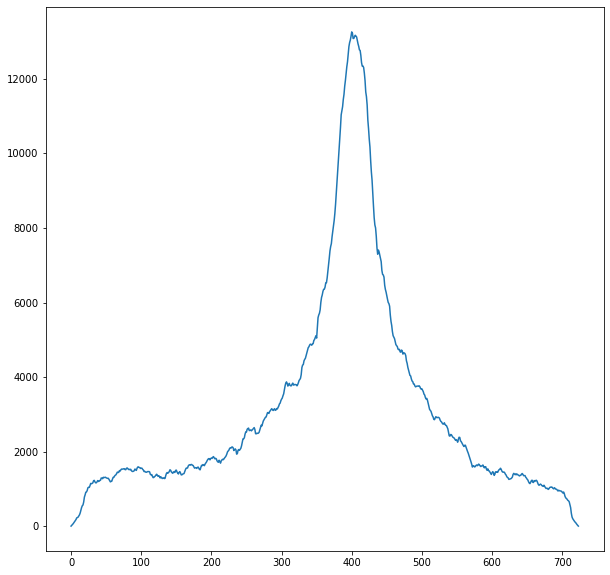

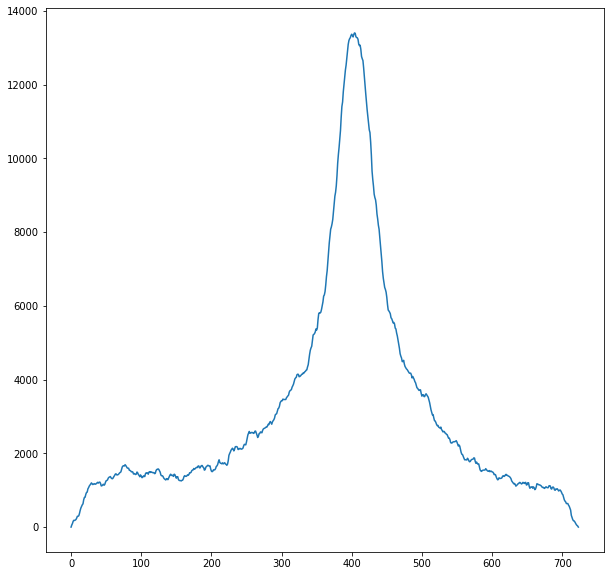

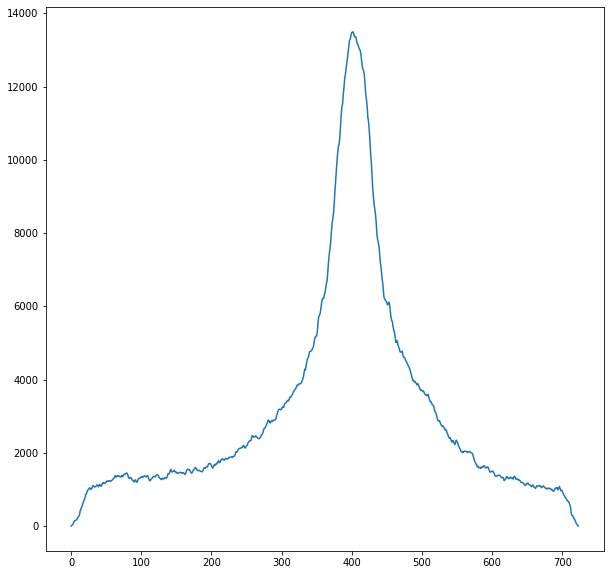

In [109]:
imagenes_colapsadas = []

for imagen in imagenes:
    
    imagen_colapsada = []
    
    for fil in range(imagen.shape[0]):
        imagen_colapsada.append(np.sum(imagen[fil, :]))
    
    plt.figure(figsize=(10,10))
    plt.plot(imagen_colapsada)
    plt.show()
    imagenes_colapsadas.append(imagen_colapsada)



Suavizo estas funciones tomando promedios adyacentes

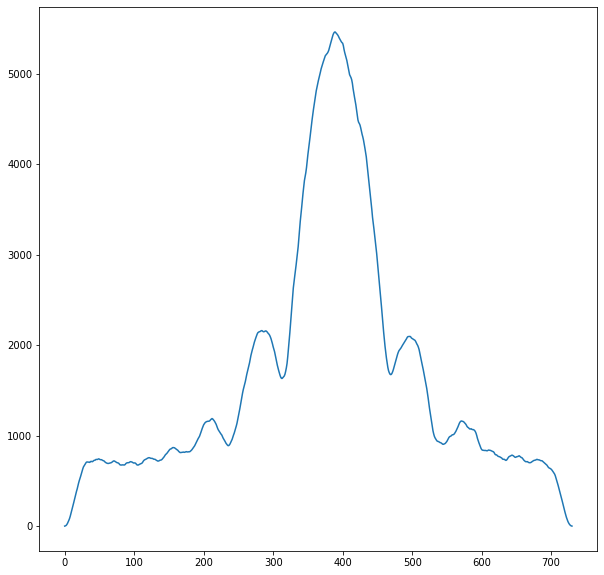

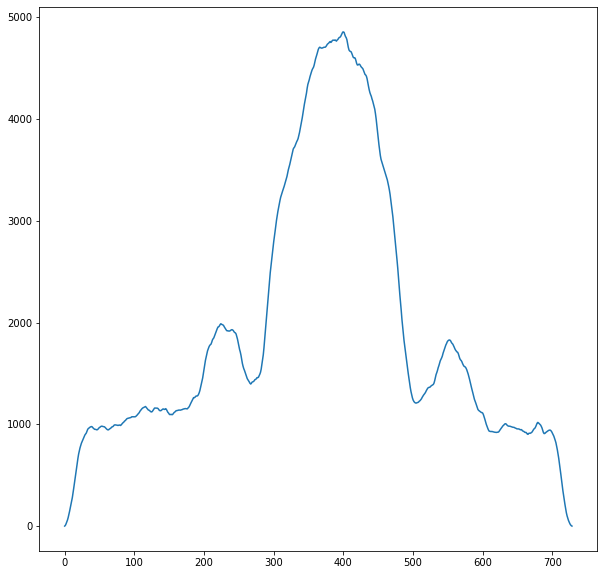

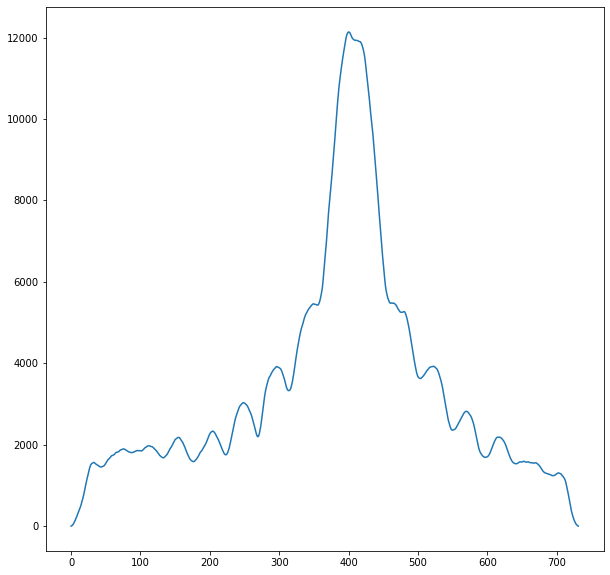

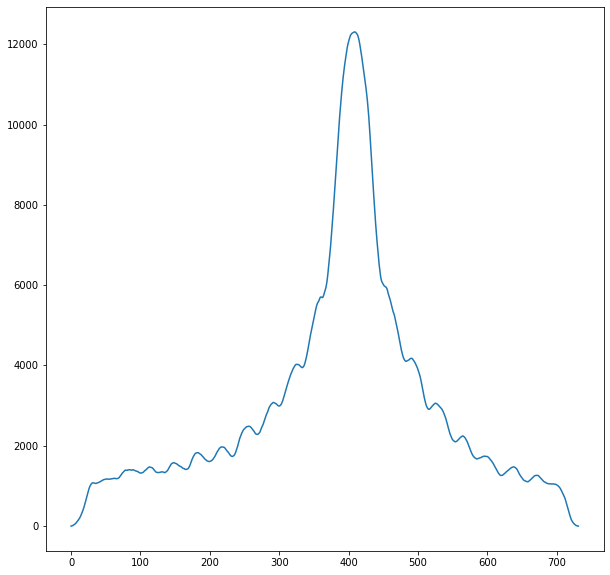

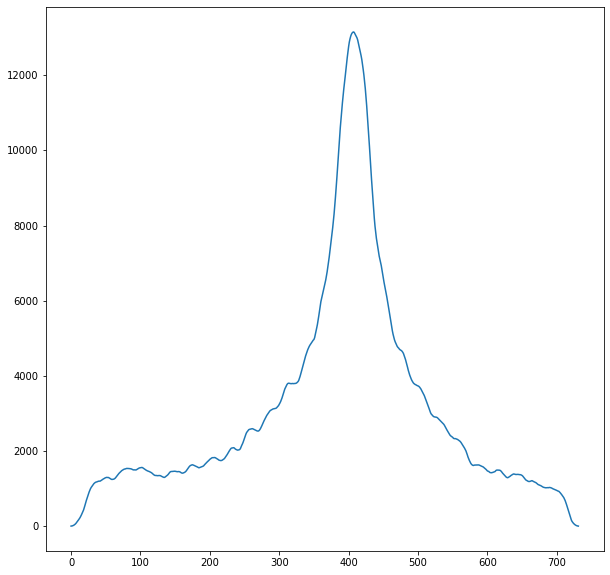

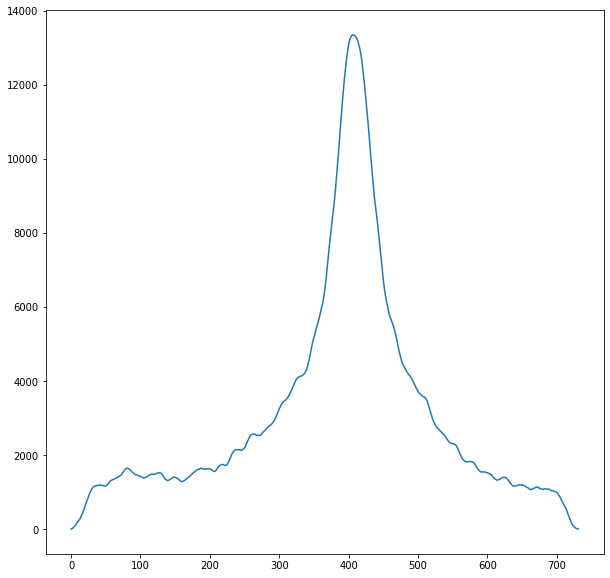

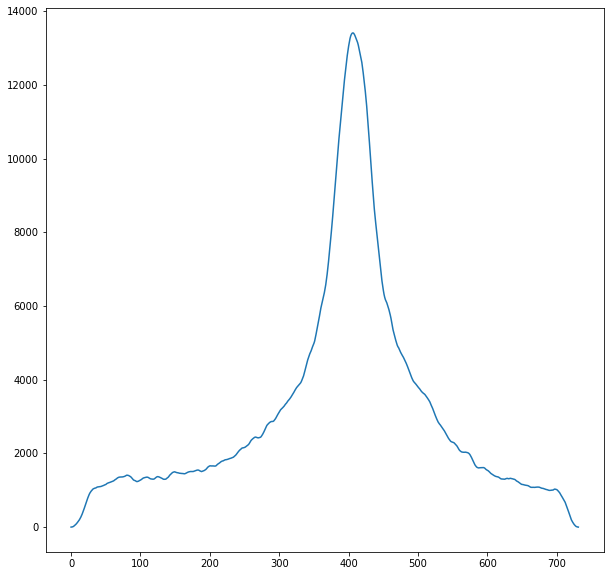

In [128]:
imagenes_suavizadas = []
for imagen in imagenes_colapsadas:
    plt.figure(figsize=(10,10))
    suavizada = np.convolve(imagen, np.ones(9)/9)
    imagenes_suavizadas.append(suavizada)
    plt.plot(suavizada)
    plt.show()

Busco los mínimos de los datos de las imágenes